### Importing Packages

In [2]:
import numpy as np
import pandas as pd
import preprocessing
import nltk

### Creating Dataframe

In [3]:
df = pd.read_csv('spam.csv', encoding = 'cp1252')

### Dropping Unnecessary Columns

In [4]:
df = df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

### Encoding Categorical Labels to Numerical

In [5]:
from sklearn.preprocessing import LabelEncoder

# encode categorical labels to numerical labels
encoder = LabelEncoder()
df['v1'] = encoder.fit_transform(df['v1'])

### Dropping Duplicates/Missing Data

In [6]:
# check for duplicates
df[df.duplicated()]

,v1,v2
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls
...,...,...
5524,1,You are awarded a SiPix Digital Camera! call 0...
5535,0,"I know you are thinkin malaria. But relax, chi..."
5539,0,Just sleeping..and surfing
5553,0,Hahaha..use your brain dear


In [7]:
df['v1'].value_counts()

v1
0    4825
1     747
Name: count, dtype: int64

In [8]:
# drop duplicates
df = df.drop_duplicates()

In [9]:
# check for missing values
df.isnull().values.any()

False

### Plotting Class Densities

<Axes: title={'center': 'Occurences of Each Label'}, xlabel='Label', ylabel='Count'>

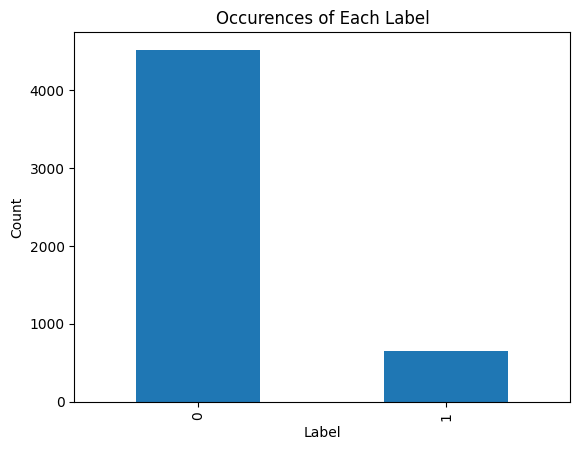

In [10]:
import matplotlib.pyplot as plt
df['v1'].value_counts().plot(kind = 'bar', xlabel = "Label", 
                             ylabel = 'Count', title = "Occurences of Each Label")

### Filtering Dataframe based on Entry Length

In [11]:
# check length of messages
df['length'] = df['v2'].apply(len)
df['length'].value_counts()

length
22     91
24     91
32     90
23     86
38     82
       ..
375     1
431     1
2       1
790     1
273     1
Name: count, Length: 274, dtype: int64

In [12]:
df = df[df['v2'].apply(lambda x: len(x) < 200)]

### Removing upper cases, punctuation, non-alphanumeric characters

In [13]:
# clean textual data
df['v2'] = preprocessing.lower(df['v2'])
df['v2'] = preprocessing.punc_removal(df['v2'])
df['v2'] = preprocessing.spec_char_removal(df['v2'])

### Tokenizing Data

In [14]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bassammalik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
tokens = df['v2'].apply(word_tokenize)
joined_tokens = [' '.join(sentence) for sentence in tokens]

### Gaussian Naive Bayes

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

X = df['v2']
Y = df['v1']



vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X = vectorizer.fit_transform(joined_tokens)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

model = GaussianNB()
model.fit(X_train.toarray(), Y_train)

Y_pred = model.predict(X_test.toarray())

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.7899408284023669
f1Score: 0.5318681318681319


### Multinomial Naive Bayes

In [17]:
model = MultinomialNB()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9723865877712031
f1Score: 0.8870967741935484


### Linear Kernel SVM

In [18]:
from sklearn.svm import SVC

svm_model = SVC(kernel = 'linear', C = 1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9792899408284024
f1Score: 0.9163346613545816


### 2nd Degree Polynomial Kernel SVM

In [19]:
svm_model = SVC(kernel = 'poly', degree = 2)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9635108481262328
f1Score: 0.8412017167381974


### 3rd Degree Polynomial Kernel SVM

In [20]:
svm_model = SVC(kernel = 'poly', degree = 3)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9299802761341223
f1Score: 0.6432160804020101


### Radial Basis Function Kernel SVM with width = .01

In [21]:
svm_model = SVC(kernel = 'rbf', gamma = .01)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.8668639053254438
f1Score: 0.0


### Radial Basis Function Kernel SVM with width = .1

In [22]:
svm_model = SVC(kernel = 'rbf', gamma = .1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9585798816568047
f1Score: 0.8157894736842105


### Radial Basis Function Kernel SVM with width = 1

In [ ]:
svm_model = SVC(kernel = 'rbf', gamma = 1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9763313609467456
f1Score: 0.9024390243902439


## LSTM


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = max(len(x) for x in X_train_seq)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Y_train_array = np.array(Y_train)
Y_test_array = np.array(Y_test)

vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train LSTM model
model.fit(X_train_pad, Y_train_array, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Predict and evaluate LSTM
Y_pred_probs = model.predict(X_test_pad)
Y_pred_lstm = (Y_pred_probs > 0.5).astype(int)

acc_lstm = accuracy_score(Y_test_array, Y_pred_lstm)
f1_lstm = f1_score(Y_test_array, Y_pred_lstm)
print("LSTM Results:")
print(f"Accuracy: {acc_lstm}")
print(f"F1 Score: {f1_lstm}")

/Users/bassammalik/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9008 - loss: 0.3472 - val_accuracy: 0.9396 - val_loss: 0.2574
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9719 - loss: 0.1470 - val_accuracy: 0.9494 - val_loss: 0.1905
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9753 - loss: 0.1076 - val_accuracy: 0.9593 - val_loss: 0.1800
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9812 - loss: 0.0945 - val_accuracy: 0.9741 - val_loss: 0.1188
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9863 - loss: 0.0708 - val_accuracy: 0.9716 - val_loss: 0.1285
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Results:
Accuracy: 0.9694280078895463
F1 Score: 0.8680851063829788


# GRU

In [34]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
gru_model.add(GRU(128, return_sequences=False))  # Using GRU instead of LSTM
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

# Train GRU model
gru_model.fit(X_train_pad, Y_train_array, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Predict and evaluate GRU
Y_pred_probs_gru = gru_model.predict(X_test_pad)
Y_pred_gru = (Y_pred_probs_gru > 0.5).astype(int)

acc_gru = accuracy_score(Y_test_array, Y_pred_gru)
f1_gru = f1_score(Y_test_array, Y_pred_gru)
print("GRU Results:")
print(f"Accuracy: {acc_gru}")
print(f"F1 Score: {f1_gru}")

/Users/bassammalik/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8253 - loss: 0.4515 - val_accuracy: 0.8533 - val_loss: 0.4171
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8724 - loss: 0.3839 - val_accuracy: 0.8533 - val_loss: 0.4008
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9259 - loss: 0.2145 - val_accuracy: 0.9889 - val_loss: 0.0533
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9921 - loss: 0.0290 - val_accuracy: 0.9827 - val_loss: 0.0635
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.9852 - val_loss: 0.0483
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU Results:
Accuracy: 0.985207100591716
F1 Score: 0.9344978165938864
